<a href="https://colab.research.google.com/github/Nisa-a/EDI-Dashboard/blob/main/DataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# EDA:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [5]:
# Decision Tree:
# Load edi dataset.
edi_df = pd.read_csv('/content/edi_df.csv')
edi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2528 entries, 0 to 2527
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SEX                2528 non-null   object 
 1   ETHNICITY          2528 non-null   object 
 2   ETHNICITYDETAILED  2528 non-null   object 
 3   DISABLETYPE        2528 non-null   object 
 4   CARELEAVER         2528 non-null   object 
 5   IMDQUINTILE        2528 non-null   object 
 6   ACCOMMODATIONTYPE  2528 non-null   object 
 7   COMMUTELENGTH      2528 non-null   object 
 8   AGEONENTRY         2528 non-null   int64  
 9   SCHOLARSHIPANY     2528 non-null   object 
 10  GREATSTARTACCESS   2528 non-null   object 
 11  BURSARY            2528 non-null   object 
 12  MODULEGRADE        2528 non-null   float64
 13  CLASSIFICATION     2528 non-null   object 
dtypes: float64(1), int64(1), object(12)
memory usage: 276.6+ KB


In [6]:
# Distribution of module grades.
histplot = px.histogram(edi_df, x='MODULEGRADE')
histplot.show()

In [7]:
# Distribution of classification.
barplot = px.bar(edi_df, x='CLASSIFICATION')
barplot.show()

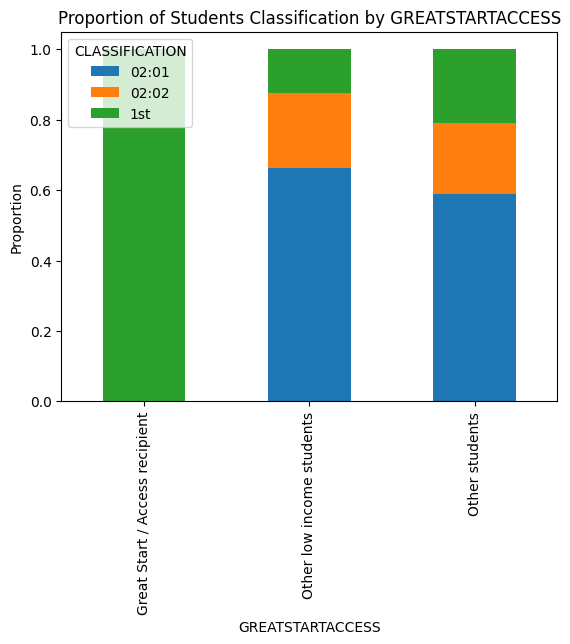

In [8]:
# Visualise the proportion of classififcation by GREATSTARTACCESS.
pd.crosstab(
    edi_df['GREATSTARTACCESS'],
    edi_df['CLASSIFICATION'],
    normalize='index'
).plot(kind='bar', stacked=True)

plt.ylabel('Proportion')
plt.xlabel('GREATSTARTACCESS')
plt.title('Proportion of Students Classification by GREATSTARTACCESS')
plt.show()

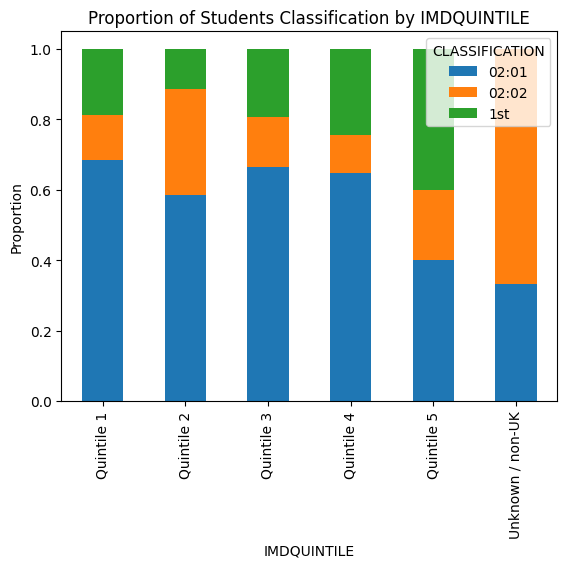

In [9]:
# Visualise the proportion of classififcation by IMDQUINTILE.
pd.crosstab(
    edi_df['IMDQUINTILE'],
    edi_df['CLASSIFICATION'],
    normalize='index'
).plot(kind='bar', stacked=True)

plt.ylabel('Proportion')
plt.xlabel('IMDQUINTILE')
plt.title('Proportion of Students Classification by IMDQUINTILE')
plt.show()

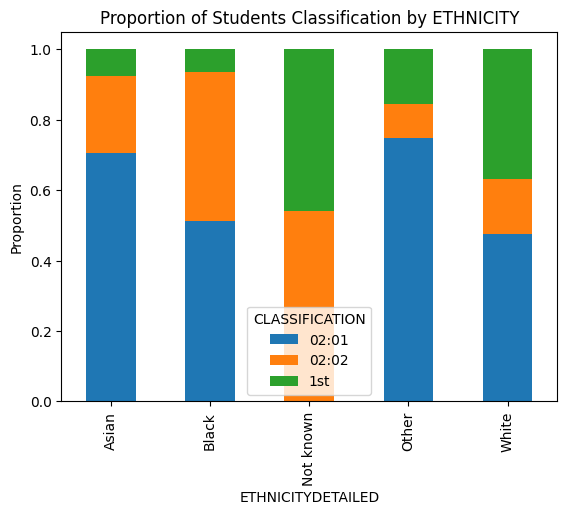

In [10]:
# Visualise the proportion of classififcation by ETHNICITY.
pd.crosstab(
    edi_df['ETHNICITY'],
    edi_df['CLASSIFICATION'],
    normalize='index'
).plot(kind='bar', stacked=True)

plt.ylabel('Proportion')
plt.xlabel('ETHNICITY')
plt.title('Proportion of Students Classification by ETHNICITY')
plt.show()

In [ ]:
# Load in pre-processed dataset.
df = pd.read_csv('/content/preprocessed_student_data.csv')
df.info()

In [11]:
# initial model:
# Install CatBoost.
!pip install catboost
# Import needed libraries.
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Define preprocessed dataset in features and target variable.
X = df.drop(columns = ['CLASSIFICATION', 'MODULEGRADE', 'ETHNICITYDETAILED'], axis=1) # our feature variables.
y = df['CLASSIFICATION'] # our target variable.
# Split X and y into training and testing groups for model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Extract only categorical columns.
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()
# Limit one-hot encoding for categorical features with up to 10 unique values.
one_hot_max_size = 10
# Initialize the CatBoostClassifier.
model = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1,
                           verbose=False, cat_features= cat_features, one_hot_max_size= one_hot_max_size)

# This code cell is adapted from:
# GeeksforGeeks, 2025. Handling categorical features with CatBoost. [Online]
# Available at: https://www.geeksforgeeks.org/machine-learning/handling-categorical-features-with-catboost/

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [12]:
# Train model.
model.fit( X_train, y_train)

In [21]:
# Display the importance of each feature.
importance = model.get_feature_importance()
# Names of the variables.
features = X_train.columns
# Display the most important features in a table.
importance_table = pd.DataFrame({
    'feature': features,
    'importance': importance
}).sort_values(by='importance', ascending=False) # ascending format
# Print table.
importance_table

# This code cell is adapted from:
# CatBoost, 2026. CatBoostClassifier. [Online]
# Available at: https://catboost.ai/docs/en/concepts/python-reference_catboostclassifier#cat_features

,feature,importance
10,IMDQUINTILE,11.352772
7,ETHNICITY,10.411103
11,ACCOMMODATIONTYPE,9.788640
5,AGEONENTRY,8.714372
17,TARIFFPOINTS,8.603124
0,COURSETITLE,7.956472
12,COMMUTELENGTH,7.125634
14,OFSENTQUALGRPLABEL,6.505357
13,OFSENTQUALGRPCODE,6.455249
15,HESATARIFFGRPCODE,4.566936


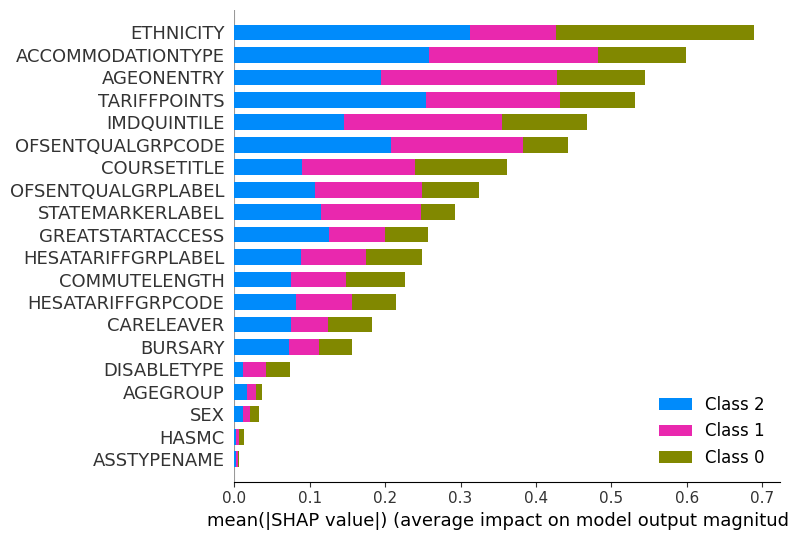

In [14]:
# Further visualise feature importance using SHAP.
import shap
import matplotlib.pyplot as plt
# Initialize explainer for model
explainer = shap.Explainer(model)
# Calculate SHAP values for classification test set.
shap_values = explainer.shap_values(X_test)

# Create a summary plot.
shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size= 0.2)
plt.show()

# This code cell is adapted from:
# GeeksforGeeks, 2025. Handling categorical features with CatBoost. [Online]
# Available at: https://www.geeksforgeeks.org/machine-learning/handling-categorical-features-with-catboost/

In [15]:
# Define EDI-focused dataset in features and target variable.
X1 = edi_df.drop(columns = ['CLASSIFICATION', 'MODULEGRADE', 'ETHNICITYDETAILED'], axis=1) # our feature variables.
y1 = edi_df['CLASSIFICATION'] # our target variable.
# Split X and y into training and testing groups for model.
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.25, random_state=42, stratify=y1)

# Extract only categorical columns.
cat_features1 = X1_train.select_dtypes(include=['object']).columns.tolist()
# Limit one-hot encoding for categorical features with up to 10 unique values.
one_hot_max_size = 10
# Initialize the CatBoostClassifier.
# Use cat_features1 instead of cat_features
model1 = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1,
                           verbose=False, cat_features= cat_features1, one_hot_max_size= one_hot_max_size)

# This code cell is adapted from:
# GeeksforGeeks, 2025. Handling categorical features with CatBoost. [Online]
# Available at: https://www.geeksforgeeks.org/machine-learning/handling-categorical-features-with-catboost/

In [16]:
# Train model.
model1.fit( X1_train, y1_train)

In [17]:
# Display the importance of each feature.
importance1 = model1.get_feature_importance()
# Names of the variables.
features1 = X1_train.columns
# Display the most important features in a table.
importance_table2 = pd.DataFrame({
    'feature': features1,
    'importance': importance1
}).sort_values(by='importance', ascending=False) # ascending format
# Print table.
importance_table2.head(10)

# This code cell is adapted from:
# CatBoost, 2026. CatBoostClassifier. [Online]
# Available at: https://catboost.ai/docs/en/concepts/python-reference_catboostclassifier#cat_features

,feature,importance
4,IMDQUINTILE,19.847792
1,ETHNICITY,15.458244
7,AGEONENTRY,14.673588
6,COMMUTELENGTH,13.973741
5,ACCOMMODATIONTYPE,13.126281
9,GREATSTARTACCESS,6.743164
3,CARELEAVER,6.519334
10,BURSARY,5.169824
0,SEX,3.308446
2,DISABLETYPE,1.040467


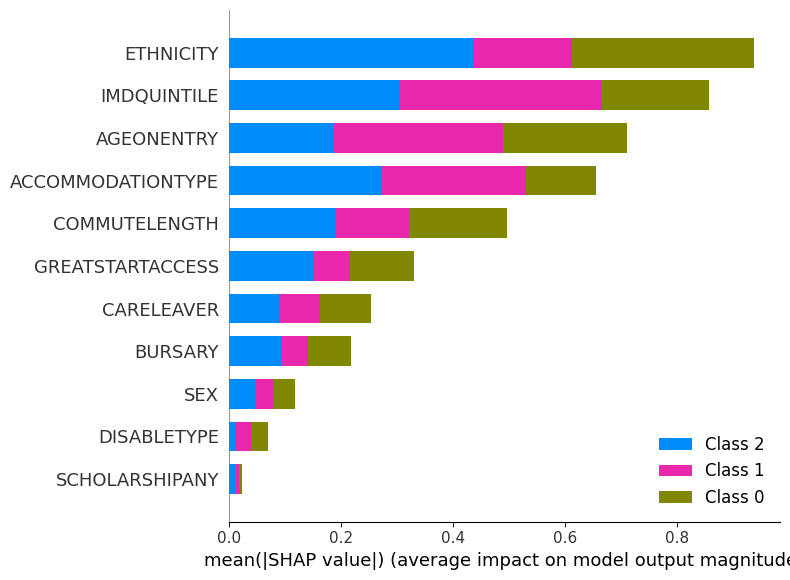

In [24]:
# Further visualise feature importance using SHAP.
# Initialize explainer for the model.
explainer1 = shap.Explainer(model1)
# Calculate SHAP values for classification test set.
shap_values1 = explainer1.shap_values(X1_test)

# Create a summary plot.
shap.summary_plot(shap_values1, X1_test, plot_type="bar")
plt.show()

# This code cell is adapted from:
# GeeksforGeeks, 2025. Handling categorical features with CatBoost. [Online]
# Available at: https://www.geeksforgeeks.org/machine-learning/handling-categorical-features-with-catboost/

In [19]:
# CatBoost for regression model - MODULEGRADE
# Import CatBoost Regression Model
from catboost import CatBoostRegressor

# Define EDI dataset in features and target variable.
X2 = edi_df.drop(columns = ['CLASSIFICATION', 'MODULEGRADE', 'ETHNICITYDETAILED'], axis=1) # our feature variables.
y2 = edi_df['MODULEGRADE'] # our target variable.
# Split X and y into training and testing groups for model.
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=42)

# Extract only categorical columns.
cat_features2 = X2_train.select_dtypes(include=['object']).columns.tolist()
# Limit one-hot encoding for categorical features with up to 10 unique values.
one_hot_max_size = 10
# Initialize the CatBoostRegressor with RMSE as the loss function.
model2 = CatBoostRegressor(loss_function='RMSE', cat_features= cat_features2, one_hot_max_size= one_hot_max_size)

# Fit the model on the training data with verbose logging every 100 iterations
model2.fit(X2_train, y2_train, verbose=100)

# This code cell is adapted from:
# GeeksforGeeks, 2025. Handling categorical features with CatBoost. [Online]
# Available at: https://www.geeksforgeeks.org/machine-learning/handling-categorical-features-with-catboost/

# GeeksforGeeks, 2025. Regression using CatBoost. [Online]
# Available at: https://www.geeksforgeeks.org/machine-learning/regression-using-catboost/

Learning rate set to 0.045298
0:	learn: 9.5490452	total: 741us	remaining: 740ms
100:	learn: 9.3618046	total: 51.1ms	remaining: 455ms
200:	learn: 9.2746781	total: 101ms	remaining: 403ms
300:	learn: 9.1998543	total: 160ms	remaining: 371ms
400:	learn: 9.1722192	total: 232ms	remaining: 347ms
500:	learn: 9.1619174	total: 285ms	remaining: 284ms
600:	learn: 9.1557498	total: 340ms	remaining: 226ms
700:	learn: 9.1526573	total: 392ms	remaining: 167ms
800:	learn: 9.1508407	total: 447ms	remaining: 111ms
900:	learn: 9.1496494	total: 500ms	remaining: 54.9ms
999:	learn: 9.1485810	total: 551ms	remaining: 0us


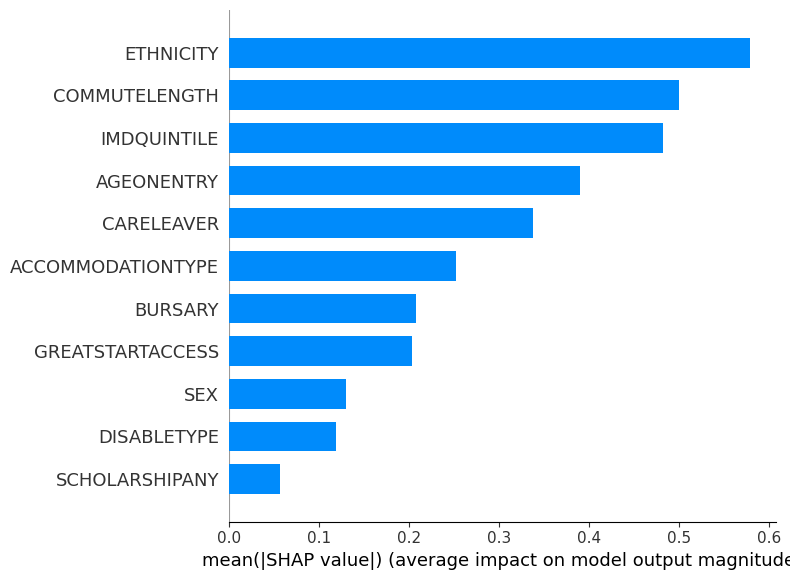

In [23]:
# Further visualise feature importance using SHAP.
import shap
import matplotlib.pyplot as plt

# Initialize explainer for the regression model.
explainer2 = shap.Explainer(model2)
# Calculate SHAP values for the regression test set.
shap_values2 = explainer2.shap_values(X2_test)

# Create a summary plot.
shap.summary_plot(shap_values2, X2_test, plot_type="bar")
plt.show()

# This code cell is adapted from:
# GeeksforGeeks, 2025. Handling categorical features with CatBoost. [Online]
# Available at: https://www.geeksforgeeks.org/machine-learning/handling-categorical-features-with-catboost/